# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

# Import data

In [3]:
import tarfile
from os import path, pardir, listdir
import skimage.io
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from scipy import ndimage
import numpy as np
import skimage.morphology as mp
import scipy.io
import skimage.color
import xml.etree.ElementTree as ET
import cv2
from skimage.color import rgb2gray
import skimage.morphology as mp

In [4]:
# setup path and unzip images
data_base_path = path.join(pardir, 'data')
data_folder = 'project-data'
tar_path = path.join(data_base_path, data_folder + '.tar.gz')
#with tarfile.open(tar_path, mode='r:gz') as tar:
#    tar.extractall(path = data_base_path)

In [5]:
# functionality for annotation extraction
def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)
    return objects

In [6]:
# load images and annotations
image_path = data_base_path + '\project-data\images\\test'
img_names = [nm for nm in listdir(image_path) if '.jpg' in nm]

annotation_path = data_base_path + '\project-data\\annotations\\test'
annotation_names = [nm for nm in listdir(annotation_path)]
annotations_xmls = [parse_file(
    path.join(annotation_path, name)) 
                    for name in annotation_names]

In [7]:
img_collection = skimage.io.imread_collection(
    [path.join(image_path, nm) for nm in img_names])

## Plotting functions

In [8]:
def plot_image(img):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    size = img.shape
    if len(size) == 3:
        ax.imshow(img)
        ax.set_title('({} px, {} px, depth {})'.format(size[0], size[1], size[2]))
    else:
        ax.imshow(img, cmap='gray')
        ax.set_title('({} px, {} px), single channel'.format(size[0], size[1]))
    plt.show()

In [9]:
def plot_with_annotation(img_nb, img = None):
    if annotations_xmls[img_nb] == [] : 
        print("No varroa here!")
        return None
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    for anno in annotations_xmls[img_nb]:
        rect = patches.Rectangle((anno['bbox'][0], 
                                  anno['bbox'][1]), 
                                  anno['bbox'][2],
                                  anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    if img is not None: # img from argument
        size = img.shape
        if len(size) == 3:
            ax.imshow(img)
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px, depth {})'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1], size[2]))
        else:
            ax.imshow(img, cmap='gray')
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px), single channel'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1]))
    else: # image from collection
        size = img_collection[img_nb].shape
        if len(size) == 3:
            ax.imshow(img_collection[img_nb])
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px, depth {})'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1], size[2]))
        else:
            ax.imshow(img_collection[img_nb], cmap='gray')
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px), single channel'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1]))
    plt.show()

In [10]:
def plot_contours(img, th_low = 0, th_high = np.Inf):
    # Find contours
    contours,l = find_contours(img)
    plt.subplots(1,1,figsize=(6,6))

    plt.gca().invert_yaxis()
    
    contours,l = contour_threshold_length(contours, th_low, th_high)
    
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    plt.title("{} contours between threholds {} and {}".format(l,
                                                              th_low,
                                                              th_high))
    plt.show()

def plot_contours_histogram(img):
    _, lengths = find_contours(img)
    plt.subplots(1,1,figsize=(10,6))
    plt.hist(lengths, bins='auto')
    plt.title("Histogram with 'auto' bins")
    plt.show()

In [46]:
def plot_boxlist_and_annotations(img_nb, boxlist) :
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    
    # plot boxes
    tmp_im = np.zeros(img_collection[img_nb].shape)
    for box in boxlist:
        #print(box)
        for x in range(box[0], box[2] + box[0]) :
            for y in range(box[1], box[3] + box[1]):
                tmp_im[y,x] = 1.0
    ax.imshow(tmp_im, cmap = 'gray')
    
    # plot annotations
    if annotations_xmls[img_nb] != [] : 
        for anno in annotations_xmls[img_nb]:
            rect = patches.Rectangle((anno['bbox'][0], 
                                      anno['bbox'][1]), 
                                      anno['bbox'][2],
                                      anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        no_varroa = len(annotations_xmls[img_nb])
    else:
        no_varroa = 0

    #ax.imshow(img_collection[img_nb], cmap='gray')
    ax.set_title('img nb {}, no varroae {}, no boxes {}'.format(
        img_nb,no_varroa, len(boxlist)))
    plt.show()

In [47]:
def plot_contours_and_annotations(img_nb, contours) :
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    
    # plot contours
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    # plot annotations
    if annotations_xmls[img_nb] != [] :
        for anno in annotations_xmls[img_nb]:
            rect = patches.Rectangle((anno['bbox'][0], 
                                      anno['bbox'][1]), 
                                      anno['bbox'][2],
                                      anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        no_varroa = len(annotations_xmls[img_nb])
    else:
        no_varroa = 0

    #ax.imshow(img_collection[img_nb], cmap='gray')
    ax.set_title('img nb {}, no varroae {}, no contours {}'.format(
        img_nb,no_varroa, len(contours)))
    
    plt.gca().invert_yaxis()
    plt.show()

## Preprocessing

In [13]:
#Thresholding the image between two thresholds
def threshold_dual(image, th1, th2):
    th_img = image.copy()
    th_img[th_img<th1] = 0
    th_img[th_img>th2] = 0
    th_img[(th_img>=th1) & (th_img<=th2)] = 255
    return th_img

def threshold(img, th):
    tmp = img.copy()
    tmp[tmp<th] = 0
    tmp[tmp>=th] = 255
    return tmp

In [16]:
def remove_yellow(img):
    out = img.copy()
    
    red = out[:,:,0]
    green = out[:,:,1]
    blue = out[:,:,2]
    
    is_yellow =  (red > 100) & (red < 250) & (green > 100) & (green < 250) & (blue > 0) & (blue < 200)
    
    red[is_yellow] = 255
    green[is_yellow] = 255
    blue[is_yellow] = 255
    
    out[:,:,0] = red
    out[:,:,1] = green
    out[:,:,2] = blue
    
    return out

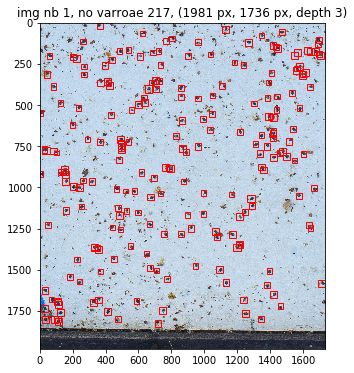

In [17]:
plot_with_annotation(1)

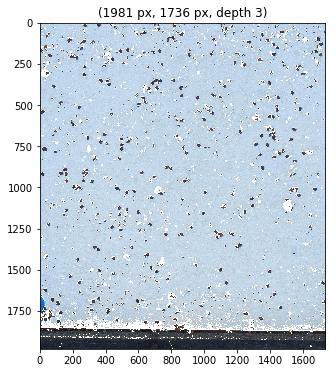

In [18]:
plot_image(remove_yellow(img_collection[1]))

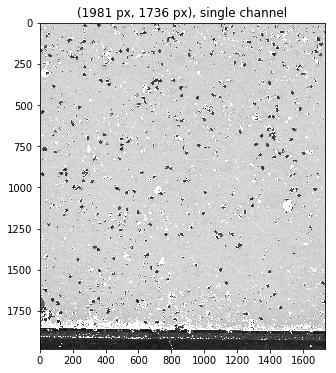

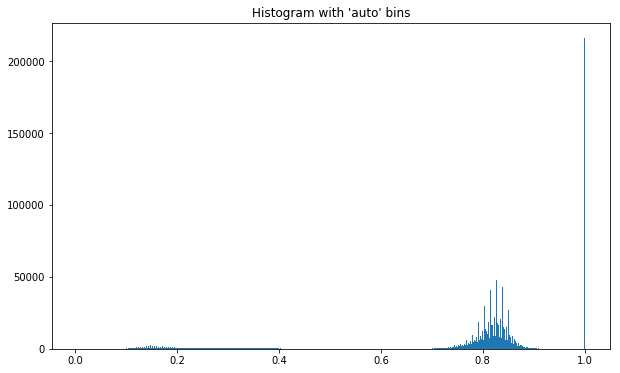

In [19]:
test_y = remove_yellow(img_collection[1])
test_y = rgb2gray(test_y)
plot_image(test_y)
test_y = np.array(test_y).flatten()
#test_y = np.squeeze(np.asarray(test_y)) # matrix -> array
test_y.shape
plt.subplots(1,1,figsize=(10,6))
plt.hist(test_y, bins='auto')
plt.title("Histogram with 'auto' bins")
plt.show()

In [24]:
def erode(img, nb):
    for i in range(nb):
        img = mp.erosion(mp.erosion(skimage.img_as_ubyte(img)))
    return img

In [31]:
def preprocess_image(img):
    img = remove_yellow(img)
    img_g = rgb2gray(img)
    img_th = threshold_dual(skimage.img_as_ubyte(img_g), 1, 100)
    img_er = erode(img_th,1)
    return img_er

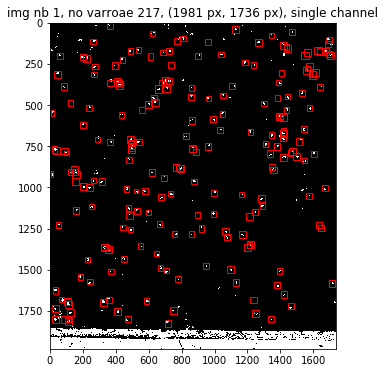

In [32]:
plot_with_annotation(1,preprocess_image(img_collection[1]))

Histogram equalization yielded bad results compared to just preprocessing the image

In [37]:
# try histogram equalization
def histogram_equalizaton(img):
    import skimage.exposure as exposure
    return skimage.img_as_ubyte(
        exposure.equalize_adapthist(img, clip_limit=0.01))

plot_with_annotation(13,preprocess_image(histogram_equalizaton(img_collection[13])))

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [34]:
def find_contours(img):
    contours = measure.find_contours(img, 0)
    lengths = []
    for cnt in contours:
        lengths.append(len(cnt))
    return contours, lengths

In [35]:
def contour_threshold_length(contours, th_low = 0, th_high = np.Inf) :
    # filters list of contours, keeps those within threshold limits
    out = []
    for n, contour in enumerate(contours):
        if len(contour) > th_low and len(contour) < th_high :
            out.append(contour)
    return out, len(out)

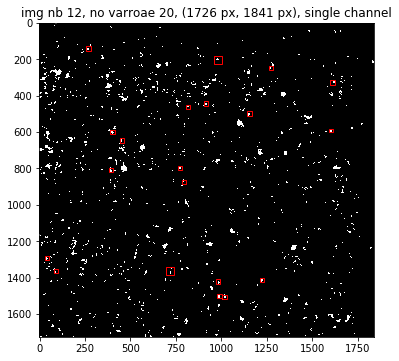

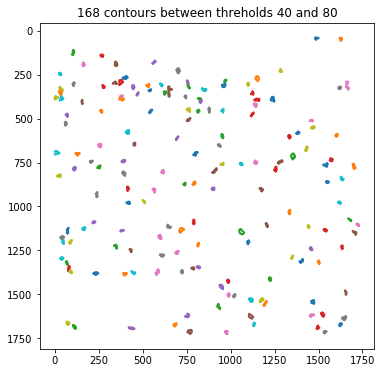

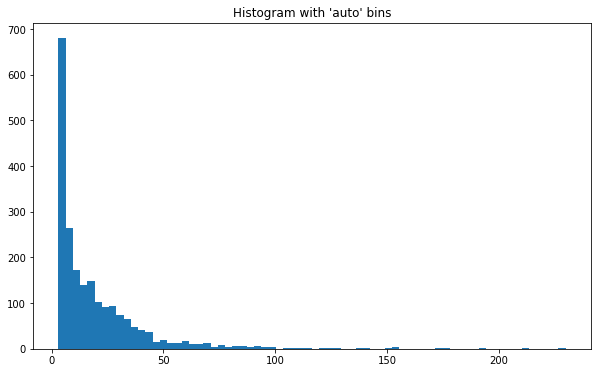

In [66]:
testimg = preprocess_image(img_collection[12])
plot_with_annotation(12,testimg)
plot_contours(testimg,40,80)
plot_contours_histogram(testimg)

In [40]:
def contours2boxlist(contours):
    # output [[x_1, y_1, w_1, h_2]
    boxes = []
    for contour in contours :
        x_min = int(np.min(contour[:,1]))
        x_max = int(np.max(contour[:,1]))
        y_min = int(np.min(contour[:,0]))
        y_max = int(np.max(contour[:,0]))
        
        boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])
    
    return boxes # [[x_1, y_1, w_1, h_2]

## test, img 13 is a good image

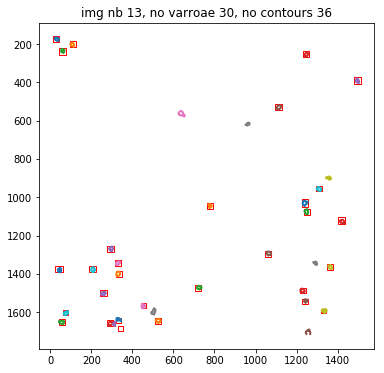

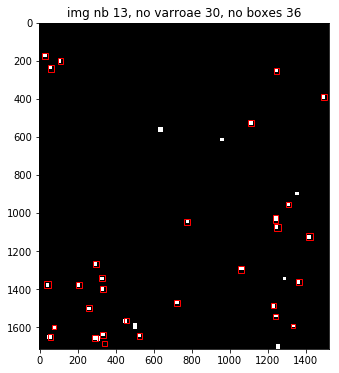

In [153]:
testimg = preprocess_image(img_collection[13])
contours,_ = find_contours(testimg)
contours,_ = contour_threshold_length(contours,50,80)
plot_contours_and_annotations(13,contours)
boxlist = contours2boxlist(contours)
plot_boxlist_and_annotations(13,boxlist)

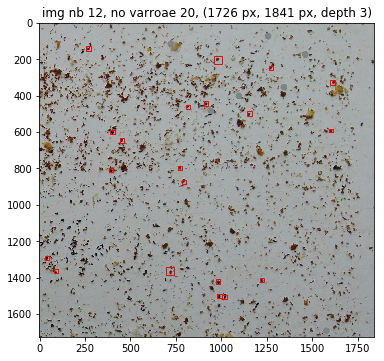

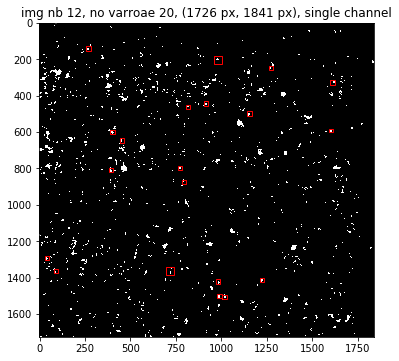

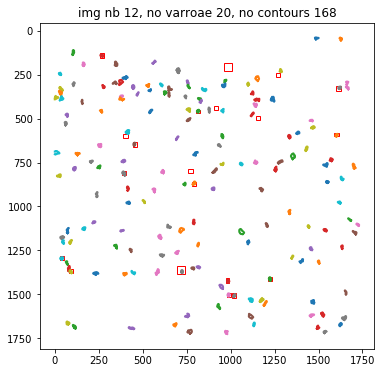

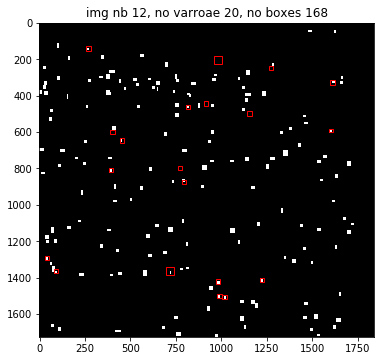

In [67]:
img_nb = 12
plot_with_annotation(img_nb, img_collection[img_nb])
testimg = preprocess_image(img_collection[img_nb])
plot_with_annotation(img_nb,testimg)
contours,_ = find_contours(testimg)
contours,_ = contour_threshold_length(contours,40,80)
plot_contours_and_annotations(img_nb,contours)
boxlist = contours2boxlist(contours)
plot_boxlist_and_annotations(img_nb,boxlist)

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [68]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    img = preprocess_image(img)
    contours,_ = find_contours(img)
    contours,_ = contour_threshold_length(contours,40,80)
    boxlist = contours2boxlist(contours)
    
    return boxlist

In [91]:
def validate_bboxlist(bboxlist_predicted):
    # input: bbox list for single image, prints scores
    def precision(tp, fp):
        return tp / (tp + fp)
    def recall(tp, fn):
        return tp / (tp + fn)
    def f1_score(tp, fp, fn):
        if (tp == 0):
            return 0
        return 2 * precision(tp, fp) * recall(tp, fn) / (precision(tp, fp) + recall(tp, fn))
    
    def iou_bbox(predicted, true):
        # [[x_1, y_1, w_1, h_2]
        # area of intersection
        x_min = max(predicted[0], true[0])
        x_max = min(predicted[0]+predicted[2], true[0]+true[2])
        y_min = max(predicted[1], true[1])
        y_max = min(predicted[1]+predicted[3], true[1]+true[3])
        if x_max < x_min or y_max < y_min : 
            
            return 0.0
        intersection_area = (x_max-x_min)*(y_max-y_min)
        
        pred_area = predicted[2]*predicted[3]
        true_area = true[2]*true[3]
        
        return intersection_area / float( pred_area+true_area-intersection_area )
    
    tp = 0
    fp = 0
    fn = 0
    
    for img_nb, annots in enumerate(annotations_xmls):
    
        bboxlist_true = []
        for bbox in annots:
            x_min = bbox['bbox'][0]
            y_min = bbox['bbox'][1]
            x_max = bbox['bbox'][2]
            y_max = bbox['bbox'][3]
            bboxlist_true.append([x_min,y_min,x_max,y_max])
            
        positives = []
        
        for bbox_pred in bboxlist_predicted[img_nb]:
            true_pos = False
            for bbox_true in bboxlist_true:
                if iou_bbox(bbox_pred, bbox_true) > 0.3:
                    true_pos = True
            positives.append(true_pos)
        
        tp += positives.count(True)
        fp += positives.count(False)
        
        negatives = []
        
        for bbox_true in bboxlist_true:
            false_neg = False
            for bbox_pred in bboxlist_predicted[img_nb]:
                if iou_bbox(bbox_pred, bbox_true) > 0.3 :
                    false_neg = True
            negatives.append(false_neg)
        
        fn += negatives.count(False)
    
    print("----------- SCORES -----------")
    print("Precision: {}".format(precision(tp,fp)))
    print("Recall   : {}".format(recall(tp,fn)))
    print("F1-score : {}".format(f1_score(tp,fp,fn)))
    print("------------------------------")

In [69]:
bboxlist = []
for img in img_collection :
    bboxlist.append(detect_by_segmentation(img))
len(bboxlist)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


50

In [92]:
validate_bboxlist(bboxlist)

----------- SCORES -----------
Precision: 0.04203670811130847
Recall   : 0.36660929432013767
F1-score : 0.07542492917847027
------------------------------


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [3]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code